In [150]:
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.cluster import KMeans
from sklearn import manifold

from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
orderdf = pd.read_csv('ignored_assets/orders.csv', parse_dates = [6,7])

In [4]:
coredf = orderdf[orderdf['dest_district_hash'].isin(orderdf['start_district_hash'].unique())]

In [100]:
dtable = pd.pivot_table(coredf, index=['start_district_hash'], 
                        columns=['dest_district_hash'], aggfunc=[np.mean],
                       values=['expected_travel_time'])

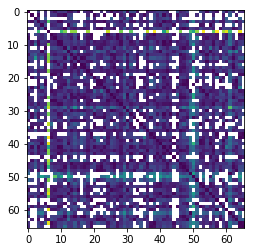

In [101]:
plt.imshow(dtable.as_matrix())

In [102]:
dtable

mean  \
                                             expected_travel_time   
dest_district_hash               08232402614a9b48895cc3d0aeb0e9f2   
start_district_hash                                                 
08232402614a9b48895cc3d0aeb0e9f2                         3.836914   
08f5b445ec6b29deba62e6fd8b0325a6                              NaN   
0a5fef95db34383403d11cb6af937309                              NaN   
1afd7afbc81ecc1b13886a569d869e8a                        28.241753   
1c60154546102e6525f68cb4f31e0657                              NaN   
1cbfbdd079ef93e74405c53fcfff8567                        33.491041   
1ecbb52d73c522f184a6fc53128b1ea1                              NaN   
2301bc920194c95cf0c7486e5675243c                        23.880362   
2350be163432e42270d2670cb3c02f80                        14.475147   
2407d482f0ffa22a947068f2551fe62c                        35.279205   
2920ece99323b4c111d6f9affc7ea034                        32.144838   
307afa4120c590b3a46cf4ff5415608a                        38.570531   
364bf755f9b270f0f9141d1a61de43ee                        38.586084   
38d5ad2d22b61109fd8e7b43cd0e8901                        15.235988   
3a43dcdff3c0b66b1acb1644ff055f9d                        40.281321   
3e12208dd0be281c92a6ab57d9a6fb32                         9.092131   
445ff793ebd3477d4a2e0b36b2db9271                              NaN   
44c097b7bd219d104050abbafe51bd49                        31.564070   
4725c39a5e5f4c188d382da3910b3f3f                        21.936880   
49ac89aa860c27e26c0836cb8dab2df2                        17.263423   
4b7f6f4e2bf237b6cc58f57142bea5c0                              NaN   
4b9e4cf2fbdc8281b8a1f9f12b80ce4d                              NaN   
4f4041f7db0c7f69892d9b74c1a7efa1                              NaN   
4f8d81b5c31af5d1ba579a65ddc8a5cb                        47.124480   
52a4e8aaa12f70020e889aed8fd5ddbc                        33.437247   
52d7b69796362a8ed1691a6cc02ddde4                         8.053516   
52e56004d92b8c74d53e1e42699cba6f                        25.708503   
58c7a4888306d8ff3a641d1c0feccbe3                        22.582424   
62afaf3288e236b389af9cfdc5206415                        28.601924   
693a21b16653871bbd455403da5412b4                        59.897080   
...                                                           ...   
82cc4851f9e4faa4e54309f8bb73fd7c                        21.261228   
8316146a6f78cc6d9f113f0390859417                              NaN   
87285a66236346350541b8815c5fae94                        33.964207   
8bb37d24db1ad665e706c2655d9c4c72                              NaN   
90c5a34f06ac86aee0fd70e2adce7d8a                        43.718453   
91690261186ae5bee8f83808ea1e4a01                        43.601808   
929ec6c160e6f52c20a4217c7978f681                        29.050683   
a5609739c6b5c2719a3752327c5e33a7                        44.791585   
a735449c5c09df639c35a7d61fad3ee5                              NaN   
a814069db8d32f0fa6e188f41059c6e1                              NaN   
b05379ac3f9b7d99370d443cfd5dcc28                        22.567760   
b26a240205c852804ff8758628c0a86a                        29.194515   
b702e920dcd2765e624dc1ce3a770512                        53.923203   
ba32abfc048219e933bee869741da911                        71.853167   
bf44d327f0232325c6d5280926d7b37d                              NaN   
c4ec24e0a58ebedaa1661e5c09e47bb5                        70.608957   
c9f855e3e13480aad0af64b418e810c3                              NaN   
ca064c2682ca48c6a21de012e87c0df5                        36.717312   
cb6041cc08444746caf6039d8b9e43cb                         8.341033   
d05052b4bda7662a084f235e880f50fa                        42.272058   
d4ec2125aff74eded207d2d915ef682f                        27.164308   
d524868ce69cb9db10fc5af177fb9423                        13.346464   
d5cb17978de290c56e84c9cf97e63186                              NaN   
dd8d3b9665536d6e05b29c2648c0e69a                        49.

In [96]:
dmatrix = dtable.as_matrix()

dmatrix_nonan = dmatrix

#Obtain mean of columns as you need, nanmean is just convenient.
col_mean = np.nanmean(dmatrix,axis=0)

#Find indicies that you need to replace
inds = np.where(np.isnan(dmatrix))

#Place column means in the indices. Align the arrays using take
dmatrix_nonan[inds]=np.take(col_mean,inds[1])

D = (dmatrix_nonan + dmatrix_nonan.T) / 2

In [97]:
mds = manifold.MDS(n_components=2, max_iter=30000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(D).embedding_

That's the mean travel time between known OD-pairs. Unlike the previous case, we are going to:
- Use Linear Regression to find the missing OD distances
- Measure distances in _time_

### A Regression Approach

In [61]:
N = len(dtable.index)

In [15]:
X = np.zeros((len(dtable.index), 2), dtype=np.float64)

In [57]:
dtable2 = pd.pivot_table(coredf, index=['start_district_hash'], 
                        columns=['dest_district_hash'], aggfunc=[len],
                       values=['expected_travel_time'])

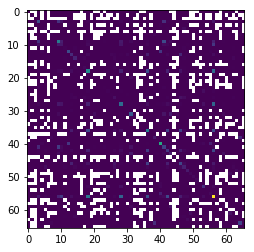

In [58]:
plt.imshow(dtable2)

In [59]:
def fake_len(x):
    #print coredf.ix[x.index[0]]
    #raise Exception
    return tuple(x)

In [106]:
dtable3 = pd.pivot_table(coredf, index=['start_district_hash'], 
                        columns=['dest_district_hash'], aggfunc=[fake_len],
                       values=['expected_travel_time']).as_matrix()

In [129]:
C = 1 / float(len(coredf))

In [133]:
def loss(x):
    
    l = 0
    lprime = np.zeros(len(x), dtype=np.float64)
    
    for i in range(N):
        xi = x[2 * i]
        yi = x[2 * i + 1]
        for j in range(N):
            xj = x[2 * j] 
            yj = x[2 * j + 1]
            if dtable3[i][j]:
                #for dijk in dtable3[i][j]:
                    dijk = np.array(dtable3[i][j])
                    squaredDistance = (xj - xi) * (xj - xi) + (yj - yi) * (yj - yi)
                    distance = np.sqrt(squaredDistance)
                    delta = squaredDistance - dijk * dijk
                
                    l += (delta * delta).sum() * C
                
                    lprime[2*i]     += 4 * delta.sum() * (xi - xj) * C
                    lprime[2*i + 1] += 4 * delta.sum() * (yi - yj) * C

                    lprime[2*j]     += 4 * delta.sum() * (xj - xi) * C
                    lprime[2*j + 1] += 4 * delta.sum() * (yj - yi) * C
    print l
    
    return (l, lprime)

In [134]:
x = np.zeros(len(dtable.index)*2, dtype=np.float64)

for i in range(N):
    x[2*i:2*i+2,] = pos[i,:]

In [135]:
loss(x)

70927.4100216


(70927.410021565665,
 array([ -4.91371680e+00,   3.95452177e+00,   2.78893324e+00,
         -4.44062057e+00,   2.01593304e+00,  -5.06180627e+00,
         -2.01416049e+01,   3.90221874e+01,  -2.39575793e+00,
         -3.54053464e+00,  -1.56367214e+01,  -3.87957318e+00,
          2.75400319e+02,  -1.30913825e+02,  -2.95370646e+01,
         -7.31627581e+00,  -9.05456246e+00,   4.59860670e+00,
         -2.42022986e+02,   1.76416773e+02,   3.12299276e+01,
          9.08359404e+00,  -1.11944028e+01,   2.34734022e+00,
         -3.57860660e+00,   9.06508280e+00,   4.63674577e+01,
         -1.03070140e+02,  -1.37468835e+01,  -9.77523783e+00,
         -1.25499682e+01,   5.67977809e+00,   1.79013113e+00,
          4.09234175e+00,  -1.01551125e+01,  -3.03788741e+00,
          6.11281133e+01,  -4.83764595e+01,  -9.12801578e+00,
         -2.26459799e+00,   1.80466974e+00,  -4.70289613e+00,
          6.38181461e+00,   3.43022066e+00,  -4.56116290e-01,
          4.64752979e+00,  -1.55647615e+00,   4.5

In [136]:
res = minimize(loss, x, method='CG', jac=True)

70927.4100216
70927.4100216
70352.3223706
68520.1751549
66798.1771201
63659.6465818
60543.6403104
58618.9541002
63367.7115161
57920.0529214
56933.4421697
56715.7197955
60095.2434029
56409.253948
56351.5642218
56230.4626614
56036.6616018
55931.2242437
55901.0810805
55802.5942209
55707.8479943
55605.3964832
55557.448775
55538.8149573
55510.0566307
55495.8037037
55443.3198753
55405.3120843
55408.4100504
55386.9272463
55357.222122
55339.9064951
55292.0738852
55253.8758911
55228.4168217
55187.2697288
55165.5314862
55116.7106029
55111.1513441
55091.011158
55055.6115281
55125.176509
55046.4133505
55038.1691565
55026.4165844
55024.0697162
55002.9937909
54996.4925531
54974.0661158
54946.6359579
54916.6302424
54899.3520165
54895.4921405
54887.8589358
54882.366515
54864.7542423
54894.7225618
54860.0290573
54854.7179468
54852.6964936
54851.3997456
54845.729365
54840.5572936
54830.2335878
54816.368072
54802.2310564
54816.4566902
54797.5590956
54791.3653817
54789.697018
54787.7323119
54784.2045793
5

54604.9560344
54604.9550364
54604.9544303
54604.9535121
54604.9532063
54604.9516401
54604.9510435
54604.9506652
54604.9505663
54604.9501469
54604.949699
54604.9490938
54604.9490841
54604.9487858
54604.9487286
54604.9486144
54604.9484691
54604.9482894
54604.948001
54604.9478479
54604.9474268
54604.9469814
54604.9463072
54604.9460843
54604.9452163
54604.9444439
54604.9433983
54604.9420497
54604.9434529
54604.9416002
54604.9412344
54604.9406591
54604.9403998
54604.9395416
54604.9387094
54604.9380693
54604.9371334
54604.9368987
54604.9361066
54604.9356951
54604.935568
54604.9347927
54604.9346214
54604.934133
54604.9339794
54604.933732
54604.9335788
54604.9332854
54604.9329926
54604.932683
54604.9325344
54604.932478
54604.932215
54604.9321595
54604.9320666
54604.9319498
54604.9317719
54604.9317106
54604.9314403
54604.9311958
54604.9309718
54604.9307182
54604.9305135
54604.9306297
54604.9304328
54604.930314
54604.9302828
54604.9300958
54604.9303879
54604.9300425
54604.9299748
54604.9298622
5

54604.8838689
54604.8838671
54604.8838902
54604.8838669
54604.8838673
54604.8838668
54604.8838667
54604.8838666
54604.8838665
54604.8838661
54604.8838657
54604.8838655
54604.8838654
54604.8838651
54604.8838646
54604.8838649
54604.8838645
54604.8838642
54604.8838642
54604.8838637
54604.8838633
54604.8838623
54604.8838612
54604.8838606
54604.8838605
54604.8838602
54604.8838596
54604.8838593
54604.8838585
54604.88386
54604.8838583
54604.883858
54604.8838579
54604.8838579
54604.8838578
54604.8838576
54604.8838574
54604.8838571
54604.883857
54604.8838569
54604.8838568
54604.8838567
54604.8838565
54604.8838562
54604.8838556
54604.8838548
54604.8838537
54604.8838524
54604.8838503
54604.8838489
54604.8838488
54604.8838471
54604.8838445
54604.8838439
54604.8838427
54604.883842
54604.8838397
54604.8838374
54604.8838358
54604.8838349
54604.8838347
54604.8838329
54604.8838318
54604.8838307
54604.88383
54604.8838321
54604.8838294
54604.8838288
54604.8838292
54604.8838285
54604.8838283
54604.883828


54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822
54604.883822

In [138]:
pos2 = np.zeros(pos.shape,dtype=np.float64)

In [141]:
for i in range(N):
    pos2[i,:] = res.x[2*i:2*i+2,]

In [145]:
posdf = pd.DataFrame(pos2, columns=['x','y'], index = dtable2.index)

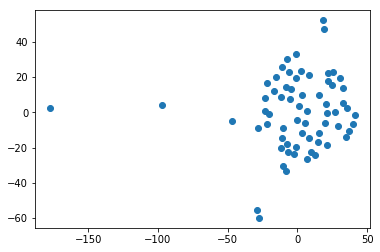

In [147]:
plt.scatter(pos2[:,0],pos2[:,1])

In [148]:
posdf.to_csv('inferred_locations.csv')

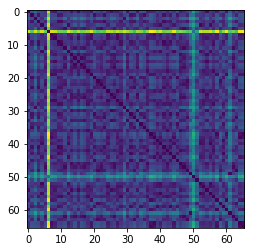

In [156]:
D2 = squareform(pdist(pos2))
plt.imshow(D2)

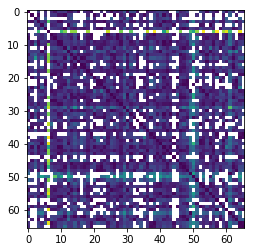

In [155]:
plt.imshow(dtable.as_matrix())

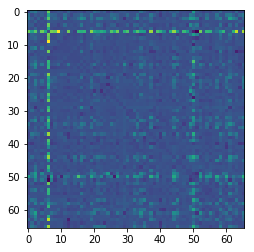

In [158]:
plt.imshow(D2 - D)

This finishes the show!

In [159]:
D2.mean()

42.268338684401066

(array([  2.,   8.,   9.,  16.,   9.,   6.,  11.,   1.,   1.,   3.]),
 array([ 2.39640938,  2.70370758,  3.01100579,  3.318304  ,  3.62560221,
         3.93290042,  4.24019863,  4.54749684,  4.85479505,  5.16209326,
         5.46939147]),
 <a list of 10 Patch objects>)

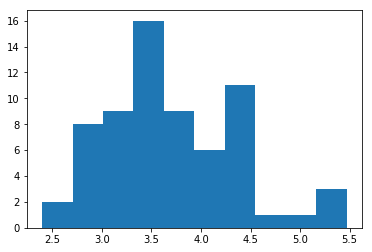

In [163]:
plt.hist(np.diag(D2))